# ARIMA Model
by **Professor Throckmorton**  
for *Time Series Econometrics*  
W&amp;M ECON 408/PUBP 616  
<a href="arima-model.slides.html">Slides</a>

## Summary
- In a **MA model**, the current value is expressed as a function of current and lagged unobservable shocks.
- In an **AR model**, the current value is expressed as a function of its lagged values plus an unobservable shock. 
- The general model is **Autoregressive Integrated Moving Average Model**, or **ARIMA($p,d,q$)**, of which MA are AR models are a special case.
- $(p,d,q)$ specifies the order for the **autoregressive**, **integrated**, and **moving average** components, respectively.
- Before we estimate ARIMA models, we should define the **ARMA($p,q$)** model and the concept of **integration**.

## ARMA Model

- An **ARMA($p,q$)** model combines an **AR($p$)** and **MA($q$)** model:

  $$
  y_t = \phi_0 + \phi_1 y_{t−1} + \cdots + \phi_p y_{t−p} + \varepsilon_t + \theta_1\varepsilon_{t-1} + \cdots + \theta_q\varepsilon_{t-q}
  $$
- As always, $\varepsilon_t$ represents a white noise process with mean $0$ and variance $\sigma^2$.
- **Stationarity**: An **ARMA($p,q$)** model is stationary if and only if its AR part is stationary (since all MA models produce stationary time series).
- **Invertibility**: An **ARMA($p,q$)** model is invertible if and only if its MA part is invertible (since the AR model part is already in AR form).
- **Causality**: An **ARMA($p, q$)** model is causal if and only if its AR part is causal, i.e., can be represented as an MA($\infty$) model.

### Key Aspects

- **Model Building**: Building an ARMA model involves plotting time series data, performing stationarity tests, selecting the order ($p, q$) of the model, estimating parameters, and diagnosing the model.
- **Estimation Methods**: Parameters in ARMA models can be estimated using methods such as conditional least squares and maximum likelihood.
- **Order Determination**: The order, ($p, q$), of an ARMA model can be determined using the ACF and PACF plots, or by using information criteria such as AIC, BIC, and HQIC.
- **Forecasting**: Covariance stationary ARMA processes can be converted to an infinite moving average for forecasting, but simpler methods are available for direct forecasting.
- **Advantages**: ARMA models can achieve high accuracy with parsimony. They often provide accurate approximations to the Wold representation with few parameters.

## Integration

- The concept of **integration** in time series analysis relates to the **stationarity** of a differenced series.
- If a time series is **integrated** of order $d$, $I(d)$, it means that the time series needs to be differenced $d$ times to become stationary.
- A time series that is $I(0)$ is covariance stationary and does not need differencing.
- **Differencing** is a way to make a nonstationary time series stationary.
- An **ARIMA($p,d,q$)** model is built by building an **ARMA($p,q$)** model for the $d$th difference of the time series.

## $I(2)$ Example

In [1]:
# Libraries
from fredapi import Fred
import pandas as pd
# Read Data
fred_api_key = pd.read_csv('fred_api_key.txt', header=None)
fred = Fred(api_key=fred_api_key.iloc[0,0])
df = fred.get_series('CHNGDPNQDSMEI').to_frame(name='gdp')
df.index = pd.DatetimeIndex(df.index.values,freq=df.index.inferred_freq)
# Convert to billions of Yuan
df['gdp'] = df['gdp']/1e9
print(f'number of rows/quarters = {len(df)}')
print(df.head(2)); print(df.tail(2))

number of rows/quarters = 127
               gdp
1992-01-01  526.28
1992-04-01  648.43
                 gdp
2023-04-01  30803.76
2023-07-01  31999.23


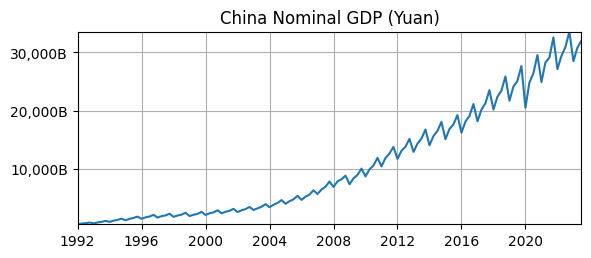

In [2]:
# Plotting
import matplotlib.pyplot as plt
# Plot
fig, ax = plt.subplots(figsize=(6.5,2.5));
ax.plot(df.gdp);
ax.set_title('China Nominal GDP (Yuan)');
ax.yaxis.set_major_formatter('{x:,.0f}B')
ax.grid(); ax.autoscale(tight=True)

Is it stationary?
- No, there is an exponential time trend, i.e., the mean is not constant.
- No, the variance is smaller at the beginning that the end.

### Seasonality

- We know that we can remove seaonality with a difference with lag $4$.
- But we could also explicitly model seasonality as its own ARMA process.
- Let's use the PACF to determine what the AR order of the seasonal component might be.
- First, let's take $\log$ to remove the exponential trend.

In [3]:
# Scientific computing
import numpy as np
# Remove expontential trend
df['loggdp'] = np.log(df['gdp'])

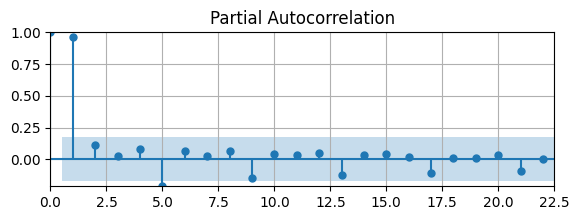

In [4]:
# Partial auto-correlation function
from statsmodels.graphics.tsaplots import plot_pacf as pacf
# Plot Autocorrelation Function
fig, ax = plt.subplots(figsize=(6.5,2))
pacf(df['loggdp'],ax); ax.grid(); ax.autoscale(tight=True)

- PACF is significant at lags $1$ and $5$ (and also almost at lags $9$, $13$,...)
- i.e., this shows the high autocorrelation at a quarterly frequency
- You could model the seasonality as $y_{s,t} = \phi_{s,0} + \phi_{s,4} y_{s,t-4} + \varepsilon_{s,t}$ (more on this later)

### First Difference

In [5]:
# Year-over-year growth rate
df['d1loggdp'] = 100*(df['loggdp'] - df['loggdp'].shift(4))

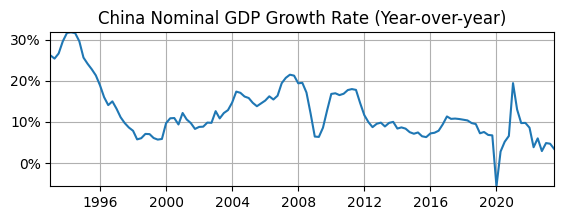

In [6]:
# Plot
fig, ax = plt.subplots(figsize=(6.5,2));
ax.plot(df['d1loggdp']);
ax.set_title('China Nominal GDP Growth Rate (Year-over-year)');
ax.yaxis.set_major_formatter('{x:.0f}%')
ax.grid(); ax.autoscale(tight=True)

Does it look stationary?
- Maybe not, it might have a downward time trend.
- Maybe not, the volatility appears to change over time.
- Maybe not, the autocorrelation looks higher at the beginning than end of sample.

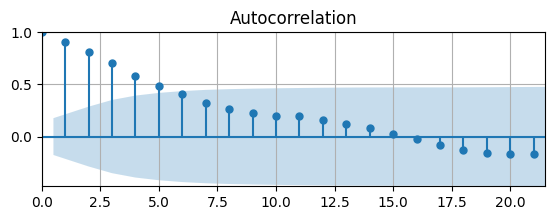

In [7]:
# Auto-correlation function
from statsmodels.graphics.tsaplots import plot_acf as acf
# Plot Autocorrelation Function
fig, ax = plt.subplots(figsize=(6.5,2))
acf(df['d1loggdp'].dropna(),ax)
ax.grid(); ax.autoscale(tight=True)

- The ACF tapers quickly, but starts to become non-zero for long lags.
- The AC is significantly different from zero for $4$ lags. Let's check the PACF to see if we can determine the order of an AR model.

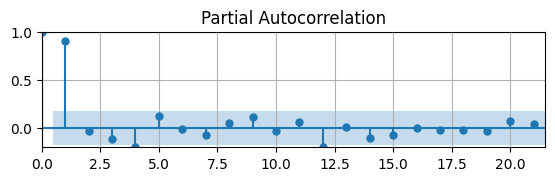

In [8]:
# Plot Autocorrelation Function
fig, ax = plt.subplots(figsize=(6.5,1.5))
pacf(df['d1loggdp'].dropna(),ax)
ax.grid(); ax.autoscale(tight=True);

- The PACF suggests to estimate an AR(1) model.
- If we assume this first-differenced data is stationary and estimate an AR(1) model, what do we get?

In [9]:
# ARIMA model
from statsmodels.tsa.arima.model import ARIMA
# Define model
mod0 = ARIMA(df['d1loggdp'],order=(1,0,0))
# Estimate model
res = mod0.fit(); summary = res.summary()
# Print summary tables
tab0 = summary.tables[0].as_html(); tab1 = summary.tables[1].as_html(); tab2 = summary.tables[2].as_html()
#print(tab0); print(tab1); print(tab2)

<table class="simpletable">
<tr>
  <th>Dep. Variable:</th>         <td>VALUE</td>      <th>  No. Observations:  </th>    <td>123</td>  
</tr>
<tr>
  <th>Model:</th>            <td>ARIMA(1, 0, 0)</td>  <th>  Log Likelihood     </th> <td>-289.294</td>
</tr>
</table>
<table class="simpletable">
<tr>
     <td></td>       <th>coef</th>     <th>std err</th>      <th>z</th>      <th>P>|z|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>const</th>  <td>   12.9494</td> <td>    2.811</td> <td>    4.606</td> <td> 0.000</td> <td>    7.440</td> <td>   18.459</td>
</tr>
<tr>
  <th>ar.L1</th>  <td>    0.9399</td> <td>    0.026</td> <td>   36.315</td> <td> 0.000</td> <td>    0.889</td> <td>    0.991</td>
</tr>
<tr>
  <th>sigma2</th> <td>    6.3511</td> <td>    0.348</td> <td>   18.243</td> <td> 0.000</td> <td>    5.669</td> <td>    7.033</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Heteroskedasticity (H):</th> <td><font color="#FF0000">3.71</font></td> <th>  Skew:              </th>  <td>0.11</td> 
</tr>
<tr>
  <th>Prob(H) (two-sided):</th>    <td>0.00</td> <th>  Kurtosis:          </th>  <td><font color="#FF0000">12.03</font></td>
</tr>
</table>

- The residuals might be heteroskedastic, i.e., their volatility varies over time.
- The kurtosis of the residuals indicate they are not normally distributed.
- That suggests that data might still be non-stationary and need to be differenced again.

### Second Difference

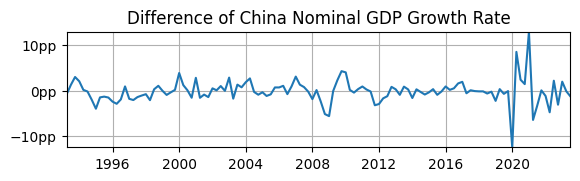

In [10]:
# Second difference
df['d2loggdp'] = df['d1loggdp'] - df['d1loggdp'].shift(1)
# Plot
fig, ax = plt.subplots(figsize=(6.5,1.5));
ax.plot(df['d2loggdp']); ax.set_title('Difference of China Nominal GDP Growth Rate')
ax.yaxis.set_major_formatter('{x:.0f}pp')
ax.grid(); ax.autoscale(tight=True)

Does it look stationary?
- Yes, the sample mean appears to be $0$.
- Yes, the volatility appears fairly constant over time, except during COVID.
- Yes, the autocorrelation also appears fairly constant over time, at least until COVID.

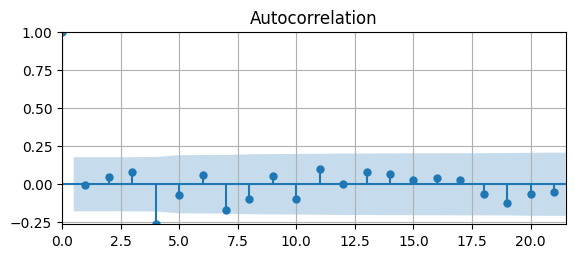

In [11]:
# Plot Autocorrelation Function
fig, ax = plt.subplots(figsize=(6.5,2.5))
acf(df['d2loggdp'].dropna(),ax)
ax.grid(); ax.autoscale(tight=True)

### Estimation

In [12]:
# ARIMA model
from statsmodels.tsa.arima.model import ARIMA
# Define model
mod0 = ARIMA(df['loggdp'],order=(1,2,0))
mod1 = ARIMA(df['d1loggdp'],order=(1,1,0))
mod2 = ARIMA(df['d2loggdp'],order=(1,0,0))

In [13]:
# Estimate model
res = mod0.fit(); summary = res.summary()
# Print summary tables
tab0 = summary.tables[0].as_html(); tab1 = summary.tables[1].as_html(); tab2 = summary.tables[2].as_html()
#print(tab0); print(tab1); print(tab2)

### Estimation Results ARIMA($1,2,0$)

<table class="simpletable">
<tr>
  <th>Dep. Variable:</th>         <td>VALUE</td>      <th>  No. Observations:  </th>   <td>127</td>  
</tr>
<tr>
  <th>Model:</th>            <td>ARIMA(1, 2, 0)</td>  <th>  Log Likelihood     </th> <td>49.700</td> 
</tr>
</table>
<table class="simpletable">
<tr>
     <td></td>       <th>coef</th>     <th>std err</th>      <th>z</th>      <th>P>|z|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>ar.L1</th>  <td>   <font color="#FF0000">-0.6646</font></td> <td>    0.076</td> <td>   -8.722</td> <td> 0.000</td> <td>   -0.814</td> <td>   -0.515</td>
</tr>
<tr>
  <th>sigma2</th> <td>    0.0263</td> <td>    0.004</td> <td>    6.541</td> <td> 0.000</td> <td>    0.018</td> <td>    0.034</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Heteroskedasticity (H):</th> <td>0.64</td> <th>  Skew:              </th> <td>-0.84</td>
</tr>
<tr>
  <th>Prob(H) (two-sided):</th>    <td>0.15</td> <th>  Kurtosis:          </th> <td>2.35</td> 
</tr>
</table>

- Warning: the AR coefficient estimate is negative!
- i.e., the way this time series has been differenced, the resulting series would flip from positive to negative every period.
- Why? ARIMA has taken the first difference at $1$ lag, instead of lag $4$, so the seasonality has not been removed.

### Estimation Results ARIMA($1,1,0$)

<table class="simpletable">
<tr>
  <th>Dep. Variable:</th>         <td>VALUE</td>      <th>  No. Observations:  </th>    <td>123</td>  
</tr>
<tr>
  <th>Model:</th>            <td>ARIMA(1, 1, 0)</td>  <th>  Log Likelihood     </th> <td>-287.368</td>
</tr>
</table>
<table class="simpletable">
<tr>
     <td></td>       <th>coef</th>     <th>std err</th>      <th>z</th>      <th>P>|z|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>ar.L1</th>  <td>    <font color="#FF0000">0.0024</font></td> <td>    0.045</td> <td>    0.053</td> <td> <font color="#FF0000">0.958</font></td> <td>   -0.087</td> <td>    0.091</td>
</tr>
<tr>
  <th>sigma2</th> <td>    6.5086</td> <td>    0.361</td> <td>   18.042</td> <td> 0.000</td> <td>    5.802</td> <td>    7.216</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Heteroskedasticity (H):</th> <td>4.22</td> <th>  Skew:              </th>  <td>0.32</td> 
</tr>
<tr>
  <th>Prob(H) (two-sided):</th>    <td>0.00</td> <th>  Kurtosis:          </th>  <td>12.12</td>
</tr>
</table>

- AR coefficient estimate is not statistically significantly different from $0$.
- That is consistent with the ACF plot, so AR(1) is model is not the best choice.

### Estimation Results ARIMA($1, 0, 0$)

<table class="simpletable">
<tr>
  <th>Dep. Variable:</th>         <td>VALUE</td>      <th>  No. Observations:  </th>    <td>122</td>  
</tr>
<tr>
  <th>Model:</th>            <td>ARIMA(1, 0, 0)</td>  <th>  Log Likelihood     </th> <td>-287.042</td>
</tr>
</table>
<table class="simpletable">
<tr>
     <td></td>       <th>coef</th>     <th>std err</th>      <th>z</th>      <th>P>|z|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>const</th>  <td>   -0.1863</td> <td>    0.231</td> <td>   -0.806</td> <td> 0.420</td> <td>   -0.639</td> <td>    0.267</td>
</tr>
<tr>
  <th>ar.L1</th>  <td>   <font color="#FF0000">-0.0025</font></td> <td>    0.045</td> <td>   -0.055</td> <td> <font color="#FF0000">0.956</font></td> <td>   -0.092</td> <td>    0.087</td>
</tr>
<tr>
  <th>sigma2</th> <td>    6.4739</td> <td>    0.357</td> <td>   18.126</td> <td> 0.000</td> <td>    5.774</td> <td>    7.174</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Heteroskedasticity (H):</th> <td>4.34</td> <th>  Skew:              </th>  <td>0.32</td> 
</tr>
<tr>
  <th>Prob(H) (two-sided):</th>    <td>0.00</td> <th>  Kurtosis:          </th>  <td>12.10</td>
</tr>
</table>

- These results are nearly identical to estimating the ARIMA($1,1,0$) with first-differenced data.
- i.e., once you remove seasonality, you can difference your data manually or have ARIMA do it for you.

### ARIMA `seasonal_order`
- `statsmodels` ARIMA also has an argument to specify a model for seasonality.
- Above, a first difference at lag 4 removed the seasonality.
- `seasonal_order=(P,D,Q,s)` is the order of seasonal model for the AR parameters, differences, MA parameters, and **periodicity** ($s$)
  .
- We saw the periodicity of the seasonality in the data was $4$ (and confirmed that with the PACF).
- Let's model the seasonality as an ARIMA($1,1,0$) (since the seasonal component is strongly autocorrelated and the data is integrated) with periodicity of $4$.
- Then we can we estimate an ARIMA($1,1,0$) using just $\log(GDP)$

In [14]:
mod3 = ARIMA(df['loggdp'],order=(1,1,0),seasonal_order=(1,1,0,4))
# Estimate model
res = mod3.fit(); summary = res.summary()
# Print summary tables
tab0 = summary.tables[0].as_html(); tab1 = summary.tables[1].as_html(); tab2 = summary.tables[2].as_html()
#tab0 = summary.tables[0].as_text(); tab1 = summary.tables[1].as_text(); tab2 = summary.tables[2].as_text()
#print(tab0); print(tab1); print(tab2)

<table class="simpletable">
<tr>
  <th>Dep. Variable:</th>              <td>VALUE</td>            <th>  No. Observations:  </th>    <td>127</td>  
</tr>
<tr>
  <th>Model:</th>           <td>ARIMA(1, 1, 0)x(1, 1, 0, 4)</td> <th>  Log Likelihood     </th>  <td>278.588</td>
</tr>
</table>
<table class="simpletable">
<tr>
     <td></td>        <th>coef</th>     <th>std err</th>      <th>z</th>      <th>P>|z|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>ar.L1</th>   <td>    <font color="#FF0000">0.0024</font></td> <td>    0.048</td> <td>    0.050</td> <td> <font color="#FF0000">0.960</font></td> <td>   -0.092</td> <td>    0.096</td>
</tr>
<tr>
  <th><font color="#FF0000">ar.S.L4</font></th> <td>   -0.2598</td> <td>    0.043</td> <td>   -6.034</td> <td> 0.000</td> <td>   -0.344</td> <td>   -0.175</td>
</tr>
<tr>
  <th>sigma2</th>  <td>    0.0006</td> <td> 3.64e-05</td> <td>   16.652</td> <td> 0.000</td> <td>    0.001</td> <td>    0.001</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Heteroskedasticity (H):</th> <td>3.09</td> <th>  Skew:              </th>  <td>-0.49</td>
</tr>
<tr>
  <th>Prob(H) (two-sided):</th>    <td>0.00</td> <th>  Kurtosis:          </th>  <td>10.65</td>
</tr>
</table>

- The estimates for the AR parameter is the same as estimating an ARIMA(1,1,0) with first-differenced $\log(GDP)$ at lag $4$.
- There is an additional AR parameter for the seasonal component `ar.S.L4`, i.e., we've controlled for the seasonality.
- While you can do this, it's more transparent to remove seasonality by first differencing, then estimate an ARIMA model.

## Unit Root(s)

- The presence of **unit roots** make time series non-stationary.
- **Trend Stationarity**: A trend-stationary time series has a **deterministic time trend** and is stationary after the trend is removed.
- **Difference Stationarity**: A difference-stationary time series has a **stochastic time trend** and becomes stationary after differencing.
- **Unit root tests**, e.g., the **augmented Dickey-Fuller test (ADF test)** are used to detect the presence of a unit root in a time series.
- Unit root tests help determine if differencing is required to achieve stationarity, suggesting a stochastic time trend.
- If an AR model has a unit root, it is called a **unit root process**, e.g., the **random walk** model.

### AR($p$) Polynomial

- Consider the AR($p$) model: $y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \varepsilon_t$
- Whether an AR($p$) produces stationary time series depends on the parameters $\phi_j$, e.g., for AR($1$), $|\phi_1|<1$
- This can be written in terms of an **AR polynomial** with the lag operator, $L$, defined as $L^jy_t \equiv y_{t-j}$

  $$
  \varepsilon_t = y_t - \phi_1 y_{t-1} - \phi_2 y_{t-2} - \dots - \phi_p y_{t-p} = (1 - \phi_1 L - \phi_2 L^2 - \dots - \phi_p L^p)y_t
  $$
- Define the **AR polynomial** as $\Phi(L) \equiv 1 - \phi_1 L - \phi_2 L^2 - \dots - \phi_p L^p$

### Unit Roots of AR($p$)

- To find the **unit roots** of an AR($p$), set $\Phi(r) = 0$ and solve for $r$ (which is sometimes complex), and the number of roots will equal the order of the polynomial.
- An AR($p$) has a **unit root** if the modulus of any of the roots equal $1$.
- For each unit root, the data must differenced to make it stationary, e.g., if there are $2$ unit roots then the data must be differenced twice.
- If the modulus of all the roots exceeds $1$, then the AR($p$) is stationary.

### Examples

- AR($1$): $y_t = \phi_1 y_{t-1} + \varepsilon_t$
  - $\Phi(r) = 0 \rightarrow 1-\phi_1 r = 0 \rightarrow r = 1/\phi_1$
  - Thus, an AR($1$) has a unit root, $r = 1$, if $\phi_1 = 1$.
  - If $\phi_1 = 1$, then $y_t = y_{t-1} + \varepsilon_t$ is a random walk model that produces non-stationary time series.
  - But the first difference $\Delta y_t = y_t - y_{t-1} = \varepsilon_t$ is stationary (since $\varepsilon_t$ is white noise).
  - Note if $|\phi_1| < 1$, then $|r|>1$ and the AR($1$) is stationary.
- AR($2$): $y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \varepsilon_t$ or $\varepsilon_t = (1 - \phi_1 L - \phi_2 L^2) y_t$
  - The AR($2$) polynomial has a factorization such that $1 - \phi_1 L - \phi_2 L^2 = (1-\lambda_1 L)(1-\lambda_2 L)$ with roots $r_1 = 1/\lambda_1$ and $r_2 = 1/\lambda_2$
  - Thus, an AR($2$) model is stationary if $|\lambda_1| < 1$ and $|\lambda_2| < 1$.
  - Given the mapping $\phi_1 = \lambda_1 + \lambda_2$ and $\phi_2 = -\lambda_1 \lambda_2$, we can prove that the modulus of both roots exceed $1$ if
    - $|\phi_2| < 1$
    - $\phi_2 + \phi_1 < 1$
    - $\phi_2 - \phi_1 < 1$

## Unit Root Test

- The **augmented Dickey-Fuller test (ADF test)** has hypotheses
  - $h_0$: The time series has a unit root, indicating it is non-stationary.
  - $h_A$: The time series does not have a unit root, suggesting it is stationary.
- Test Procedure
  - Write an AR($p$) model with the AR polynomial, $\Phi(L)y_t = \varepsilon_t$.
  - If the AR polynomial has a unit root, it can be written as $\Phi(L) = \varphi(L)(1 - L)$ where $\varphi(L) = 1 - \varphi_1 L - \cdots - \varphi_{p-1} L^{p-1}$.
  - Define $\Delta y_t = (1 - L)y_t = y_t - y_{t-1}$.
  - An AR($p$) model with a unit root is then $\Phi(L)y_t = \varphi(L)(1 - L)y_t = \varphi(L)\Delta y_t = \varepsilon_t$.
  - Thus, testing $\Phi(L)$ for a unit root is equivalent to the test $h_0: \rho = 0$ vs. $h_A: \rho < 0$ in
  
  $$
  \Delta y_t = \rho y_{t-1} + \varphi_1 \Delta y_{t-1} + \cdots + \varphi_{p-1} \Delta y_{t-p+1} + \varepsilon_t
  $$
- **Intuition**: A stationary process reverts to its mean, so $\Delta y_t$ should be negatively related to $y_{t-1}$.

### `adfuller`

- In `statsmodels`, the function `adfuller()` conducts an ADF unit root test.
- If the p-value is smaller than $0.05$, then the series is probably stationary.

In [15]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
# Function to organize ADF test results
def adf_test(data):
    keys = ['Test Statistic','p-value','# of Lags','# of Obs']
    values = adfuller(data)
    test = pd.DataFrame.from_dict(dict(zip(keys,values[0:4])),
                                  orient='index',columns=[data.name])
    return test

### ADF test results

In [16]:
test = adf_test(df['d1loggdp'].dropna())
#print(test.to_markdown())

|                |    d1loggdp |
|:---------------|------------:|
| Test Statistic |  -3.1799    |
| p-value        |   0.0211781 |
| # of Lags      |   4         |
| # of Obs       | 118         |

- The p-value < $0.05$, reject the null hypothesis that the process is non-stationary.
- The number of lags is chosen by minimizing the **Akaike Information Criterion (AIC)** (more on that soon).

In [17]:
dl = []
for column in df.columns:
    test = adf_test(df[column].dropna())
    dl.append(test)
results = pd.concat(dl, axis=1)
#print(results.to_markdown())

|                |     gdp |     loggdp |    d1loggdp |      d2loggdp |
|:---------------|--------:|-----------:|------------:|--------------:|
| Test Statistic |   4.294 |  -1.27023  |  -3.1799    |  -6.54055     |
| p-value        |   1     |   0.642682 |   0.0211781 |   9.37063e-09 |
| # of Lags      |   7     |   8        |   4         |   3           |
| # of Obs       | 119     | 118        | 118         | 118           |

- China GDP has a unit root after taking `log`.
- China GDP is probably stationary after removing seasonality and converting to growth rate (p-value < $0.05$).
- Second difference of China GDP is almost certainly stationary.

### U.S. Unemployment Rate

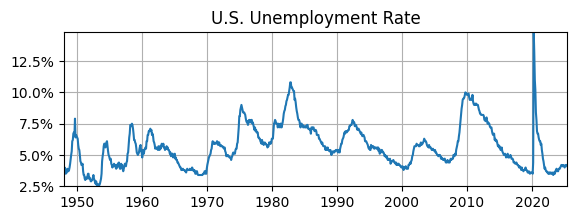

In [18]:
# Read Data
fred_api_key = pd.read_csv('fred_api_key.txt', header=None)
fred = Fred(api_key=fred_api_key.iloc[0,0])
data = fred.get_series('UNRATE').to_frame(name='UR')
# Plot
fig, ax = plt.subplots(figsize=(6.5,2));
ax.plot(data.UR); ax.set_title('U.S. Unemployment Rate');
ax.yaxis.set_major_formatter('{x:,.1f}%')
ax.grid(); ax.autoscale(tight=True)

In [19]:
adf_UR = adf_test(data.UR)
print(adf_UR)

                        UR
Test Statistic   -3.918852
p-value           0.001900
# of Lags         1.000000
# of Obs        928.000000


- ADF test suggests that U.S. unemployment rate is stationary (p-value < 0.05).
- This doesn't necessarily contradict the ACF, which suggested the UR might be non-stationary, i.e., we couldn't tell with certainty.
- This result may not be surprising since modeling the UR as AR($1$) led to an estimate of the AC parameter that was less than $1$, i.e., it was not close to a random walk.

## Order Determination
- There are a lot of possible choices for the orders of an ARIMA($p,d,q$) model.
- Even if the data is not seasonal and already stationary, there are plenty of possibilities for an ARMA($p,q$) model.
- In the ADF tests above, `adfuller` selected the $p$ lags for an AR($p$) model for the first-differenced time series to test for a unit root.
- How do we select the best orders for an ARMA($p,q$) model?

## Information Criterion

- Information criteria are used for order determination (i.e., model selection) of ARMA($p,q$) models.
- In `adfuller`, the default method to select lags is the **Akaike Information Criterion (AIC)**. Another choice is the **Bayesian Information Criterion (BIC)** (a.k.a. **Schwarz Information Criterion (SIC)**).
- The **AIC** and **BIC** are commonly used in economics research using time series data.
- But there are other choices as well, e.g., the **Hannan-Quinn Information Criterion (HQIC)**.
- The goal of **AIC**, **BIC**, and **HQIC** is to estimate the out-of-sample mean square prediction error, so **a smaller value indicates a better model**.

### AIC vs. BIC

- Let $\mathcal{L}$ be the maximized log-likelihood of the model, $K$ be the number of estimated parameters, and $n$ be the sample size of the data.
  - $AIC = -2 \mathcal{L} + 2 K$
  - $BIC = -2 \mathcal{L} + \log(n) K$
- The key difference is that
  - **AIC** has a tendency to overestimate the model order.
  - **BIC** places a bigger penalty on model complexity, hence the best model is parsimonious relative to **AIC**.
- **Consistency**, i.e., as the sample size increases does the information criteria select the true model?
  - **AIC** is not consistent, but it is asymptotically efficient, which is relevant for forecasting (more on that much later).
  - **BIC** is consistent.
- When **AIC** and **BIC** suggest different choices, most people will choose the parsimonious model using the **BIC**.

### Likelihood Function

- **Likelihood function**: Probability of the observed time series data given a model and its parameterization.
- **Maximum Likelihood Estimation**: For a given model, find the parameterization that maximizes the likelihood function, i.e., such that the observed time series has a higher probability than with any other parameterizaiton.
- The likelihood function is the **joint probability distribution** of all observations.
- In ARMA/ARIMA models, the likelihood function is just a product of Gaussian/normal distributions since that is the distribution of the errors/innovations.
- **Order determination/model selection**:
  - Given some time series data and a menu of models, which model has the highest likelihood and is relatively parsimonious?
  - e.g., for each AR model we can compute the ordinary least squares estimates and then the value of the likelihood function for that parameterization.

#### Example
- Assume an **MA(2) model**: $y_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2}$, where $\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$ are i.i.d. normal errors. Note: by construction $y_t$ is uncorrelated with $y_{t-3}$
- The likelihood function is the **joint probability distribution** of the observations $y_1, y_2, \dots, y_T$, given parameters of the model $\Theta = \{\mu, \theta_1, \theta_2, \sigma^2\}$

  $$
  \mathcal{L}(\Theta| y_1, \dots, y_T) = \prod_{t=1}^{T} f(y_t | y_{t-1}, y_{t-2}; \Theta)
  $$
  where $f(y_t | y_{t-1}, y_{t-2}; \Theta)$ is the **conditional normal density**

  $$
  f(y_t | y_{t-1}, y_{t-2};\Theta) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -\frac{\varepsilon_t^2}{2\sigma^2} \right)
  $$

- Combining the previous expressions and substituting out $\varepsilon_t$ for $y_t - \mu - \theta_1 \varepsilon_{t-1} - \theta_2 \varepsilon_{t-2}$ yields

  $$
  \mathcal{L}(\Theta) = \prod_{t=1}^{T} \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -\frac{(y_t - \mu - \theta_1 \varepsilon_{t-1} - \theta_2 \varepsilon_{t-2})^2}{2\sigma^2} \right)
  $$

- The **log-likelihood function** (i.e., taking natural log converts a product to a sum) is

  $$
  \log \mathcal{L}(\Theta) = -\frac{T}{2} \log(2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_{t=1}^{T} (y_t - \mu - \theta_1 \varepsilon_{t-1} - \theta_2 \varepsilon_{t-2})^2
  $$

- To estimate $\mu, \theta_1, \theta_2, \sigma^2$, maximize this log-likelihood function, i.e., $\hat{\Theta} = \textrm{arg max}_\Theta \log \mathcal{L}(\Theta)$.
- Because $\log \mathcal{L}(\Theta)$ is nonlinear in the parameters, numerical methods such as **nonlinear optimization** or the **conditional likelihood approach** are used in practice.